In [1]:
import os
import random
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import PolynomialFeatures
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt

import pywt
from scipy.signal import medfilt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

max_seed_value = np.iinfo(np.uint32).max
min_seed_value = np.iinfo(np.uint32).min

def seed_everything(seed, workers: bool = False) -> int:
    if seed is None:
        env_seed = os.environ.get("PL_GLOBAL_SEED")
        if env_seed is None:
            seed = _select_seed_randomly(min_seed_value, max_seed_value)
            rank_zero_warn(f"No seed found, seed set to {seed}")
        else:
            try:
                seed = int(env_seed)
            except ValueError:
                seed = _select_seed_randomly(min_seed_value, max_seed_value)
                rank_zero_warn(f"Invalid seed found: {repr(env_seed)}, seed set to {seed}")
    elif not isinstance(seed, int):
        seed = int(seed)

    if not (min_seed_value <= seed <= max_seed_value):
        rank_zero_warn(f"{seed} is not in bounds, numpy accepts from {min_seed_value} to {max_seed_value}")
        seed = _select_seed_randomly(min_seed_value, max_seed_value)

    #print (f"Global seed set to {seed}")
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ["PL_SEED_WORKERS"] = f"{int(workers)}"

if not os.path.exists("fold1"):
    os.mkdir("fold1")
if not os.path.exists("folds"):
    os.mkdir("folds")

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head()

,Time,Patient_id,Patient_bd,Patient_gender,Diagnosis,Comment,D_class,D_bin_class,datetime,Week
0,18/6/25 11:36:54,26,7/29/72,male,Z00,NaN,0,0,2025-06-18 11:36:54,1
1,18/6/25 11:45:25,28,6/15/80,female,Z00,NaN,0,0,2025-06-18 11:45:25,1
2,18/6/25 12:15:36,2,7/8/95,female,Z00,NaN,0,0,2025-06-18 12:15:36,1
3,18/6/25 12:23:04,4,1/18/99,female,Z00,NaN,0,0,2025-06-18 12:23:04,1
4,18/6/25 12:27:49,11,6/23/95,male,Z00,NaN,0,0,2025-06-18 12:27:49,1


In [4]:
df.Diagnosis.value_counts()

Diagnosis
Z00    167
K29    138
B18    138
E11    128
K76    128
N18    128
C34    100
J44    100
Name: count, dtype: int64

In [5]:
pid2icd = {}
for i, v in zip(df.Patient_id.values, df.Diagnosis.values):
    pid2icd[i] = v.split(' ')[-1]

In [6]:
pid2datetime = {}
for i, v in zip(df.Patient_id.values, df.datetime.values):
    # Convert to datetime object
    dt_object = datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
    # Convert to timestamp (seconds since epoch)
    timestamp = dt_object.timestamp()
    pid2datetime[i] = int(timestamp)

In [7]:
data = pd.read_json('dataset.json')

In [8]:
live_channels = []
for i, (patient_id, value) in enumerate(zip(data.columns, data.values[-1])):    
    valid_channels = set()
    for channel_dict in value[0]['channels']:
        cid = channel_dict['id']
        sig_unique = len(set(channel_dict['samples']))
        if sig_unique!=1:
            valid_channels.add(cid)
    live_channels.append(valid_channels)
    #print ('#', i, 'id', patient_id, valid_channels)
    #break
union = set.intersection(*live_channels)
print (sorted(union))
print (len(union))

['R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R2', 'R3', 'R5', 'R8']
11


In [9]:
data

,18,939,278,419,1035,1032,931,482,227,566,...,41,668,1025,174,646,264,822,932,1041,830
patient_id,18,939,278,419,1035,1032,931,482,227,566,...,41,668,1025,174,646,264,822,932,1041,830
patient_birthdate,9/13/03,10/7/48,2/18/58,10/26/69,9/17/85,3/20/61,1/28/56,6/19/92,4/23/75,11/5/60,...,12/29/75,4/20/48,1/15/47,3/18/78,2/23/54,2/14/90,2/7/85,11/23/48,6/28/57,11/25/57
patien_gender,0,0,1,1,1,1,0,1,0,0,...,1,1,0,1,1,0,1,0,0,1
patient_diag_class,0,7,3,4,5,5,5,6,2,6,...,0,6,5,6,1,2,3,5,5,7
startDateTime,2025-06-19T11:47:04.873065788Z,2025-08-15T13:49:35.748289891Z,2025-07-04T09:28:57.369978666Z,2025-07-14T09:53:57.493125143Z,2025-08-27T15:08:02.261874998Z,2025-08-25T09:03:03.117007754Z,2025-08-26T12:10:54.104188582Z,2025-07-17T08:15:14.163320919Z,2025-07-01T12:02:49.663185401Z,2025-07-31T09:34:00.547381382Z,...,2025-06-20T09:23:52.965939046Z,2025-08-07T07:14:17.233341749Z,2025-08-22T10:14:47.129928943Z,2025-07-04T07:15:03.266762704Z,2025-07-24T11:34:36.371405211Z,2025-07-07T07:20:22.372998934Z,2025-08-12T11:57:26.591453575Z,2025-08-26T11:54:42.006467530Z,2025-08-27T14:02:39.090937291Z,2025-08-12T09:59:47.133770390Z
startTimeGases,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
endTimeGases,450,450,450,450,450,450,450,450,450,450,...,450,450,450,450,450,450,450,450,450,450
durationSec,920,920,920,920,920,920,920,920,920,920,...,920,920,920,920,920,920,920,920,920,920
sensors,"[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...",...,"[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'...","[{'id': 'enose', 'sampleRate': 0.4, 'channels'..."


In [10]:
datetime_series = pd.to_datetime(data.values[4])

In [11]:
week_numbers = datetime_series.isocalendar().week.to_numpy()

In [12]:
week_numbers = week_numbers-np.min(week_numbers)+1

In [13]:
pid2meta = {}
for patient_id, bd, gender, date, week_number in zip(data.columns, data.values[1], data.values[2], datetime_series, week_numbers):
    #print (patient_id, bd, type(date), week_number)
    parts = bd.split('/')
    yearpart = parts[-1]
    if int(yearpart)<20:
        bd_new = '/'.join(parts[:2]+['20'+parts[2]])
    else:
        bd_new = '/'.join(parts[:2]+['19'+parts[2]])
    date_from_string = pd.to_datetime(bd_new, format='%m/%d/%Y')
    
    # Make timestamp date timezone-naive (remove timezone info)
    
    timestamp_date_naive = date.tz_localize(None)

    # Calculate age in years
    age_in_years = int((timestamp_date_naive - date_from_string).days / 365.25)
    
    pid2meta[patient_id] = (gender, age_in_years, week_number)

In [14]:
pid2data = {}
for i, (patient_id, value) in enumerate(zip(data.columns, data.values[-1])):
    pid2data[patient_id] = []
    for channel_dict in value[0]['channels']:
        cid = channel_dict['id']
        if cid in union:
            print (cid)
            series = channel_dict['samples']#[8:180]
            
            coeffs = pywt.wavedec(series, 'db4', level=4)
            coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
            smoothed_data = pywt.waverec(coeffs, 'db4')

            #smoothed_data = medfilt(series, kernel_size=5)
            
            result_data = minmax_scale(smoothed_data, axis=0)
            
            pid2data[patient_id].append(result_data)
    pid2data[patient_id] = np.array(pid2data[patient_id])
    #break

R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17


R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17


R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11


R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8


R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2
R3
R5
R8
R11
R12
R13
R14
R15
R16
R17
R2


In [15]:
len(pid2data)

1027

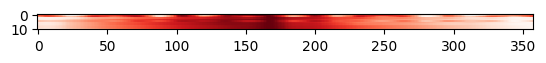

In [16]:
plt.imshow(pid2data[556], cmap='Reds', interpolation='none')# 18
plt.show()

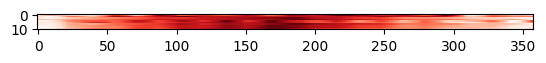

In [17]:
plt.imshow(pid2data[148], cmap='Reds', interpolation='none')
plt.show()

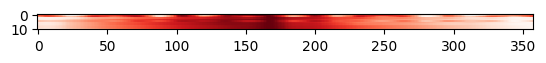

In [18]:
plt.imshow(pid2data[556], cmap='Reds', interpolation='none')
plt.show()

In [ ]:
# initial data: data (11, 358)
original_data = pid2data[18]

In [ ]:
# polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
poly.fit_transform(original_data.T).T  # (11 + C(11,2) + 11 = 77, 358)
None

In [21]:
seed_everything(369)

In [ ]:
# generate 256 random combination
n_new_channels = 256
n_base_channels = 374

# random weights
weights = np.random.uniform(-13, 13, (n_new_channels, n_base_channels))

In [ ]:
pid2data_ext = {}
for pid in pid2data:
    original_data = pid2data[pid]
    poly_features = poly.transform(original_data.T).T  # (11 + C(11,2) + 11 = 77, 358)
    # 2. combine original and polynomial feautures
    extended_features = np.vstack([original_data, poly_features])
    
    # new channels as linear combination
    new_channels = np.dot(weights, extended_features)  # (256, 358)
    
    #nonlinear_expanded = apply_nonlinearities(original_data)

    # 4. combine with original data
    final_data = np.vstack(
        [original_data, new_channels]
    )  # (11 + 256 = 267, 358)

    # 5. normalization
    final_data = (final_data - np.mean(final_data, axis=1, keepdims=True)) / np.std(final_data, axis=1, keepdims=True)
    
    pid2data_ext[pid] = final_data

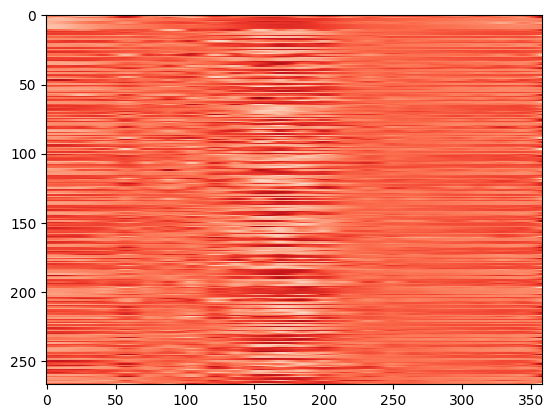

In [24]:
plt.imshow(pid2data_ext[pid], cmap='Reds', interpolation='none')
plt.show()

In [25]:
np.min(pid2data_ext[18]), np.max(pid2data_ext[18])

(-3.496334955057673, 3.8179566798435522)

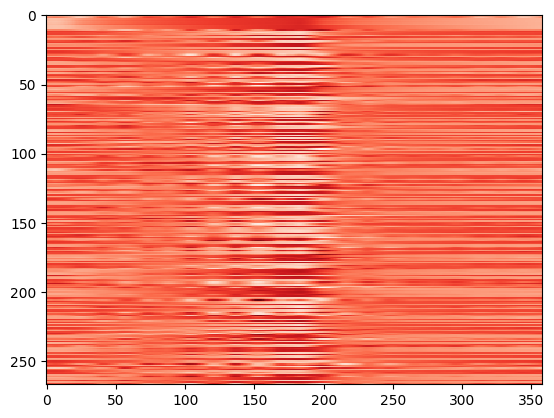

In [26]:
plt.imshow(pid2data_ext[18], cmap='Reds', interpolation='none')
plt.show()

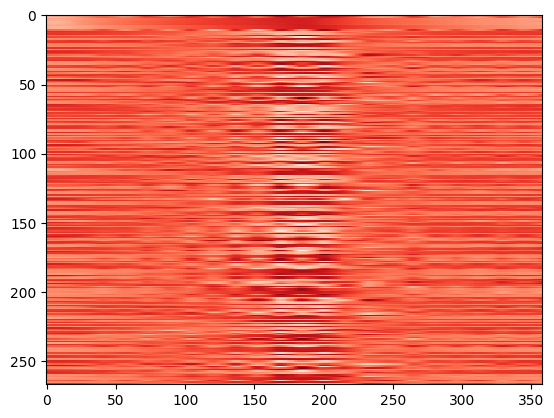

In [27]:
plt.imshow(pid2data_ext[404], cmap='Reds', interpolation='none')
plt.show()

In [28]:
pid2data_ext[404].shape

(267, 358)

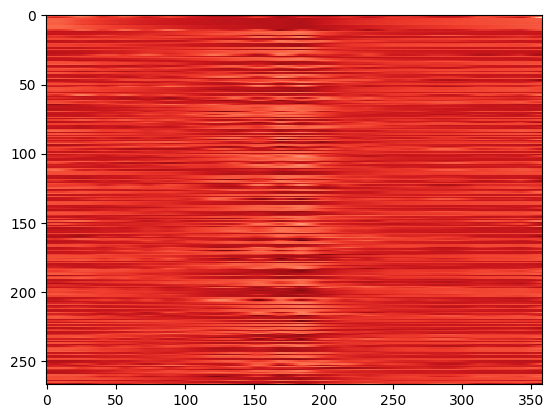

In [29]:
plt.imshow(pid2data_ext[119], cmap='Reds', interpolation='none')
plt.show()

In [ ]:
class HeightWiseCNN(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(267, 15), padding=(0, 2))
        self.pool = nn.MaxPool2d(kernel_size=(1, 2))
        # "same"-паддинг по ширине
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(1, 10), padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(1, 20), padding='same')

        self.head_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (B,32,1,358)
        x = self.pool(x)           # (B,32,1,179)
        x = F.relu(self.conv2(x))  # (B,64,1,179)
        x = self.pool(x)           # (B,64,1,89)
        x = F.relu(self.conv3(x))  # (B,128,1,89)
        x = self.head_pool(x)      # (B,128,1,1)
        x = x.flatten(1)           # (B,128)
        x = self.dropout(x)
        #x = F.relu(self.fc1(x))
        x = self.fc1(x)
        x = self.dropout(x)
        return self.fc2(x)
    
#     def get_embeddings(self, x):
#         # forward pass до fc2
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = F.relu(self.conv3(x))
#         x = self.head_pool(x)
#         x = x.flatten(1)
#         x = self.dropout(x)
#         #embeddings = F.relu(self.fc1(x))
#         embeddings = self.fc1(x)
#         return embeddings

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]       # (267, 358) np.float32
        label = int(self.labels[idx]) # 0..7
        if self.transform:
            sample = self.transform(sample)  # -> (1,267,358) torch.float32
        return sample, label

#
transform = transforms.Compose([
    transforms.ToTensor(),  # (H,W) -> (1,H,W), [0,1]
])

def accuracy(outputs, labels):
    preds = outputs.argmax(1)
    return (preds == labels).float().mean().item()

def roc_auc(outputs, labels):
    # probability of a second class
    probs = F.softmax(outputs, dim=1)[:, 1]  # shape: (batch_size,)
    return roc_auc_score(labels.cpu().numpy(), probs.detach().cpu().numpy())

In [31]:
code2id = {v: i for i, v in enumerate(sorted(set(pid2icd.values())))}
id2code = {code2id[key]:key for key in code2id}

In [32]:
pid_ts_values = sorted(pid2datetime.items(), key=lambda item: item[1])

In [33]:
indices = np.array([pid for pid, ts in pid_ts_values])
codes_by_time = np.array([pid2icd[pid] for pid, ts in pid_ts_values])

In [34]:
fold1 = {
    #'code': (train_weeks, train_pos, val_weeks, val_pos)
    'K29': (set([4,5,6,7,8,9,10,11]), 99, set([1,2,3]), 39),
    'B18': (set([1,4,5,6,7,8,9,11]), 109, set([2,3,10]), 29),
    'C34': (set([1,2,3,4,5,6,7,11]), 64, set([8,9,10]), 36),
    'Z00': (set([1,2,3,4,5,6,7,8]), 133, set([9,10,11]), 34),
    'K76': (set([1,5,6,7,8,9,10,11]), 96, set([2,3,4]), 32),
    'E11': (set([4,5,6,7,8,9,10,11]), 91, set([1,2,3]), 37),
    'J44': (set([1,2,3,4,8,9,10]), 80, set([5,6,7,11]), 20),
    'N18': (set([1,5,6,7,8,9,11]), 101, set([2,3,4,10]), 27)
}

In [35]:
for dir_name, fld in [('fold1', fold1)]:
    for code in code2id:
        trainweeks = fld[code][0]
        valweeks = fld[code][2]
        train_ids, val_ids = [], []
        for pid in pid2data_ext.keys():
            week = pid2meta[pid][2]
            if week in trainweeks:
                train_ids.append(pid)
            else:
                val_ids.append(pid)

        with open(dir_name+'/'+code+'.val.fold.0.txt', 'w') as f:
            s = ' '.join([str(i) for i in val_ids])
            f.write(s)

In [36]:
X, y, ids = [], [], []
for pid in pid2data_ext:
    h,w = pid2data_ext[pid].shape
    if h==267 and w>=358 and pid2icd[pid] in code2id:
        X.append( pid2data_ext[pid][:,:358] )
        code = pid2icd[pid]
        y.append(code2id[code])
        ids.append(pid)
        
X, y, ids = np.array(X).astype(np.float32), np.array(y), np.array(ids)
print (X.shape, y.shape, ids.shape)

(1026, 267, 358) (1026,) (1026,)


In [ ]:
for splt in ['fold1']:
    print (splt)
    for code in code2id:
        seed_everything(369)
        scores = []
        for fold in range(1):
            with open(splt+'/'+code+'.val.fold.'+str(fold)+'.txt') as f:
                ids_cv = np.array([int(i) for i in f.readline().split(' ')])
            mask = np.isin(ids, ids_cv)

            #X_train, X_cv = X[~mask][:,:,8:180], X[mask][:,:,8:180]
            X_train, X_cv = X[~mask], X[mask]
            y_train, y_cv = y[~mask], y[mask]
            ids_train, ids_cv = ids[~mask], ids[mask]

            y_train_bin, y_cv_bin = y_train==code2id[code], y_cv==code2id[code]

            dataset_train = CustomDataset(X_train, y_train_bin, transform=transform)
            dataset_cv = CustomDataset(X_cv, y_cv_bin, transform=transform)

            train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0)
            val_loader = DataLoader(dataset_cv, batch_size=16, shuffle=False, num_workers=0)

            # init
            device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
            model = HeightWiseCNN(num_classes=2).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=1e-3)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

            num_epochs = 20
            best_val_auc = 0.0
            best_path = "heightwise_cnn_best.pth"

            for epoch in range(num_epochs):
                # ---- Train ----
                model.train()
                tr_loss_sum, tr_count = 0.0, 0
                outputs, targets = [], []
                for batch_idx, (data, target) in enumerate(train_loader):
                    data, target = data.to(device), target.to(device, dtype=torch.long)
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                    bs = data.size(0)
                    tr_loss_sum += loss.item() * bs

                    outputs.append(output)
                    targets.append(target)
                    tr_count += bs

        #             if batch_idx % 10 == 0:
        #                 print(f"[{epoch:02d}/{num_epochs}] batch {batch_idx}/{len(train_loader)} "
        #                       f"loss={loss.item():.4f}")

                tr_loss = tr_loss_sum / tr_count
                outputs, targets = torch.cat(outputs), torch.cat(targets)
                tr_auc = roc_auc(outputs, targets)

                # ---- Val ----
                model.eval()
                val_loss_sum, val_count = 0.0, 0
                outputs, targets = [], []
                with torch.no_grad():
                    for data, target in val_loader:
                        data, target = data.to(device), target.to(device, dtype=torch.long)
                        output = model(data)
                        loss = criterion(output, target)
                        bs = data.size(0)
                        val_loss_sum += loss.item() * bs
                        outputs.append(output)
                        targets.append(target)
                        #probabilities = F.softmax(output, dim=1)
                        val_count += bs

                val_loss = val_loss_sum / val_count

                outputs, targets = torch.cat(outputs), torch.cat(targets)
                val_auc = roc_auc(outputs, targets)

                scheduler.step()

                #print(f"Epoch {epoch:02d}: "
                #      f"train_loss={tr_loss:.4f} train_auc={tr_auc:.4f} | "
                #      f"val_loss={val_loss:.4f} val_auc={val_auc:.4f} | "
                #      f"lr={optimizer.param_groups[0]['lr']:.2e}")

                # best validation checkpoint
                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                    #torch.save({
                    #    "model_state": model.state_dict(),
                    #    "val_auc": best_val_auc,
                    #    "epoch": epoch,
                    #}, best_path)
                    #print (f"\tBest checkpoints: val_auc={best_val_auc:.4f}")

                    with open('folds/'+code+'.fold.'+str(fold)+'.txt', 'w') as f:
                        s = ' '.join([str(i) for i in np.array(targets.detach().cpu())])
                        f.write(s)
                        f.write('\n')
                        s = ' '.join([str(i) for i in np.array((1/(1+torch.exp(-outputs))[:,1]).detach().cpu())])
                        f.write(s)

            print ('code {} ({}/{}) {}'.format(code, np.sum(y_cv_bin), y_cv_bin.shape[0], best_val_auc))
            scores.append(best_val_auc)

fold1


/home/blinoff/miniconda3/envs/py38/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,


code B18 (29/310) 0.6149220763283839
code C34 (36/299) 0.7313054499366286
code E11 (37/262) 0.5482282282282283
code J44 (20/349) 0.5082066869300912
code K29 (39/262) 0.5644475106358515
code K76 (32/337) 0.5996926229508197
code N18 (27/426) 0.6965562053281351
code Z00 (34/260) 0.6345653305570016


In [38]:
# fold1
# code B18 (29/310) 0.6149220763283839
# code C34 (36/299) 0.7313054499366286
# code E11 (37/262) 0.5482282282282283
# code J44 (20/349) 0.5082066869300912
# code K29 (39/262) 0.5644475106358515
# code K76 (32/337) 0.5996926229508197
# code N18 (27/426) 0.6965562053281351
# code Z00 (34/260) 0.6345653305570016